In [11]:
import sys
sys.path.insert(1, '/home/richard/nfmc_jax/')
import nfmc_jax
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy
from sklearn.neighbors import KernelDensity
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax.scipy.stats import multivariate_normal as mvn
import chaospy

# 1d Gaussian likelihood and prior test for nfmc_jax

In [12]:
def log_like(x, mu=jnp.array([0]), cov=jnp.array([[1.0]])):
    return mvn.logpdf(x, mu, cov)

def log_prior(x, mu=jnp.array([0]), cov=jnp.array([[5.0]])):
    return mvn.logpdf(x, mu, cov)

key = jax.random.PRNGKey(100)
prior_samples = jax.random.multivariate_normal(key, mean=jnp.array([0.0]), 
                                               cov=jnp.array([[5.0]]), shape=(100,))
prior_samples.shape[1]

1

In [13]:
trace = nfmc_jax.infer_nfomc(log_like, log_prior, prior_samples, 
                             log_like_args=(jnp.array([0]), jnp.array([[1.0]])), 
                             log_prior_args=(jnp.array([0]), jnp.array([[5.0]])), 
                             vmap=True, parallel_backend=None, n0=100, iteration=5, 
                             N_AF=1000, expl_top_AF=10, expl_latent=1, expl_top_qw=1, local_thresh=3,
                             nfmc_draws=100, nf_iter=10, k_trunc=0.5, ess_tol=1.0, eps_z=0.01,
                             inference_mode="sampling", cull_lowp_tol=0.01, max_cull_frac=0.0,
                             trainable_qw=False, beta_max=1)

Inference mode is sampling. Maximum beta is set to 1.
beta=0.00
logL= [ -0.967112    -1.4324826   -0.9230754   -4.8195515   -2.625857
  -0.9194897   -2.1679356   -9.180287    -7.801723   -10.364269
  -2.036684    -0.92413455  -3.0078373   -3.153923    -0.9194898
  -2.1636975   -0.91996825  -0.9189385   -0.95910245  -1.0288308
  -0.9593568   -1.1421375   -1.110261    -3.0541925   -1.0283517
  -4.1604195   -2.54561     -1.0135734   -3.6288457   -3.760651
  -1.6728456   -1.1833749   -1.0691547   -1.4558048   -1.1908294
  -3.796238    -2.025325    -2.4662032   -0.99570525  -4.286995
  -4.4855165   -1.756584    -0.9443636   -2.7853103   -1.0053862
  -7.048806    -0.9780154   -0.9780192   -8.890059    -2.6489441
  -8.4162      -1.5059344   -2.8372438   -0.9245142   -1.0811704
  -2.5256405   -0.9189418   -7.420944    -4.766707    -1.1329049
  -2.240269    -0.93362236  -5.709158    -0.931148    -0.93990564
 -17.17826     -1.7074981   -5.096134    -2.8298497   -0.926305
  -2.630465    -6.192772

qw weighted mean = 0.006869570352137089
qw weighted sd = 0.9290890693664551
quw weighted mean = 0.022005809471011162
quw weighted sd = 0.9255214929580688


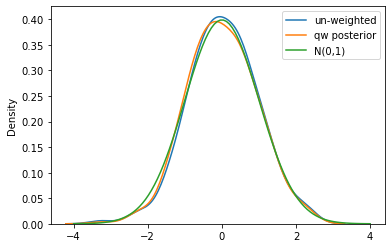

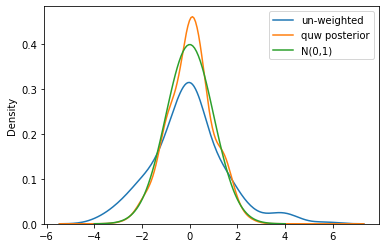

In [14]:
posterior = trace['qw_posterior'][0]
betas = trace['betas']

x = np.asarray(posterior).squeeze()
w = np.clip(trace['qw_posterior_weights'][0], a_min=0, a_max=None)

qw_mu = jnp.average(x, weights=w)
qw_sd = jnp.sqrt(jnp.average((x - qw_mu) ** 2, weights=w))

print(f'qw weighted mean = {qw_mu}')
print(f'qw weighted sd = {qw_sd}')

def gauss(z):
    return np.exp(-z ** 2 / 2) / np.sqrt(2 * np.pi)

z = np.linspace(-4, 4, 100)
plt.figure()
sns.kdeplot(x, label='un-weighted')
sns.kdeplot(x, weights=w, label='qw posterior')
plt.plot(z, gauss(z), label='N(0,1)')
plt.legend(loc='upper right')

posterior = trace['quw_posterior'][0]

x = np.asarray(posterior).squeeze()
w = np.clip(trace['quw_posterior_weights'][0], a_min=0, a_max=None)

quw_mu = jnp.average(x, weights=w)
quw_sd = jnp.sqrt(jnp.average((x - quw_mu) ** 2, weights=w))

print(f'quw weighted mean = {quw_mu}')
print(f'quw weighted sd = {quw_sd}')

z = np.linspace(-4, 4, 100)
plt.figure()
sns.kdeplot(x, label='un-weighted')
sns.kdeplot(x, weights=w, label='quw posterior')
plt.plot(z, gauss(z), label='N(0,1)')
plt.legend(loc='upper right')

dict_keys(['q1_w', 'q1_uw', 'q_nfmc_1_w', 'q_nfmc_1_uw', 'q_nfmc_2_w', 'q_nfmc_2_uw'])
dict_keys(['q1_w', 'q1_uw', 'q_nfmc_1_w', 'q_nfmc_1_uw', 'q_nfmc_2_w', 'q_nfmc_2_uw'])


<AxesSubplot:ylabel='Density'>

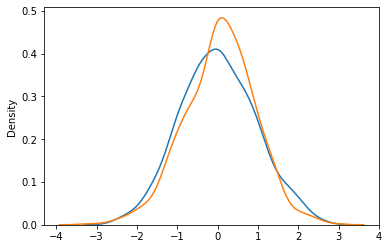

In [15]:
q_models = trace['q_models'][0]
print(q_models.keys())
q1 = q_models['q1_w'][0]
import torch
q1_samples, _ = q1.sample(1000, device='cpu') 
q1_samples = q1_samples.numpy()

sns.kdeplot(q1_samples.squeeze())

q_models = trace['q_models'][0]
print(q_models.keys())
q2 = q_models['q_nfmc_1_w'][0]
import torch
q2_samples, _ = q2.sample(1000, device='cpu') 
q2_samples = q2_samples.numpy()

sns.kdeplot(q2_samples.squeeze())

In [20]:
q_models = trace['q_models'][0]
q = q_models['q_nfmc_6_w'][0]
q_samples, logq = q.sample(5000, device='cpu') 
q_samples, logq = q_samples.numpy(), logq.numpy()
print(jnp.shape(q_samples))
print(jnp.shape(logq))

def gauss(z):
    return np.exp(-z ** 2 / 2) / np.sqrt(2 * np.pi)

llk = jax.vmap(lambda x: log_like(x, mu=0, sigma=1))(jnp.asarray(q_samples))
lpr = jax.vmap(lambda x: log_prior(x))(jnp.asarray(q_samples))
print(jnp.shape(lpr))
logw = llk + lpr - logq.reshape(len(logq), 1)
print(jnp.shape(logw))
logw = logw - logsumexp(logw)
w = jnp.exp(logw)
print(w)

z = np.linspace(-4, 4, 100)
sns.kdeplot(q_samples.squeeze(), weights=np.asarray(w).squeeze())
plt.plot(z, gauss(z), label='N(0,1)')
plt.legend(loc='upper right')

(5000, 1)
(5000,)


TypeError: log_like() got an unexpected keyword argument 'sigma'

# 2D double Gaussian example

In [ ]:
key = jax.random.PRNGKey(100)
prior_samples = jax.random.multivariate_normal(key, mean=jnp.array([0.0, 0.0]), 
                                               cov=100 * jnp.eye(2), shape=(20,))
prior_samples.shape[1]

n=2
#shift the peaks to be in between the samples - diagonals
mu1 = jnp.ones(n) * 0.625 # #2(.25)
mu2 = jnp.ones(n) * -0.325 # #2(-.375)

scale_stdev = 1 #4
stdev = 0.1 / scale_stdev
sigma = jnp.power(stdev, 2) * jnp.eye(n)
isigma = jnp.linalg.inv(sigma)
dsigma = jnp.linalg.det(sigma)

w1 = 0.3  # one mode with 0.3 of the mass 
w2 = 1 - w1  # the other mode with 0.7 of the mass

def log_like(x):
    log_like1 = jax.scipy.stats.multivariate_normal.logpdf(x, mu1, sigma)
    log_like2 = jax.scipy.stats.multivariate_normal.logpdf(x, mu2, sigma)
    return logsumexp(jnp.array([jnp.log(w1) + log_like1, jnp.log(w2) + log_like2]), axis=0)

def log_prior(x, mu=jnp.zeros(2), cov=100 * jnp.eye(2)):
    return jax.scipy.stats.multivariate_normal.logpdf(x, mu, cov)

In [ ]:
trace = nfmc_jax.sample_nfo(log_like, log_prior, prior_samples, log_like_args=(), 
                            log_prior_args=(jnp.zeros(2), 100 * jnp.eye(2)),
                            vmap=True, parallel_backend=None, n0=20, iteration=5, aN=100, bN=10, num_local=2,
                            nfmc_samples=20, nf_iter=10, k_trunc=0.5, ess_tol=1.0)

In [ ]:
sns.kdeplot(x=trace['posterior'][0][:,0], y=trace['posterior'][0][:,1],
            weights=trace['posterior_weights'][0])

# Prior samples sanity check ...

In [ ]:
n=1
n_iter=1 #sinf iterations 
n_prior = 10#number of sobol points
n_samples = n_prior #not used explicitly
n0=n_prior
N=n_samples
#get sobol sequence for initial samples
low,high=-1.0,1.0
dist1d = chaospy.Iid(chaospy.Uniform(lower=low,upper=high),n)
init_prior=dist1d
init_prior = np.atleast_2d(dist1d.sample(n_prior,rule='sobol')).T
# init_prior=None
transform=None#'ahh'#'ahh' #turn off pymc3 transform 
if(transform is not None):
    trname='t'
    #logit( (x-a) / (b-a) )
    init_prior = None#inv_logit(init_prior,low,high)#logit((init_prior-low) /(high-low))
else:
    trname='nt'
knots=None#100 #default None
bw=0.5#None#1.#None#0.5#1. #default 2.0
redraw=False #don't redraw samples at every iteration, my local change
layers=2
ktrunc=np.inf #currently SKIPPING
bw_use_pq=True #whether to use pq loss in determining bw
t_ess=0.5
g_AF=1
aN=int(2*N)#10
bN=1#2#int(N/2)
beta_max=1.0

In [ ]:
print(np.shape(init_prior))